In [7]:
image_path = '/home/tli_project/Desktop/Data/T4/stage1/211121/211121_P3630_N1/seg_1_211121_P3630_N1.tif'
##you either run the stable_branch func or you define the path for stable neuron
# stable_path = '/home/tli_project/Desktop/Data/T4/stage1/211121/211121_P3630_N1/stable_GFP_SyNRA_211121_brain4.1.tif'
cols_path = '/home/tli_project/Desktop/Data/T4/stage1/211121/211121_P3630_N1/211104_neuron1_rot(-15)_Cols.tif'
save_path = '/home/tli_project/Desktop/Data/T4/stage1/211121/211121_P3630_N1'
save_name = 'GFP_SyNRA_211121_brain4.1.tif'

##
start_age = 36.5
stab_limit = 4 #(No. of timepoints for stable branches calculation)
nor_fact = 1 #this is for normalizing Col_occpancy. for now there is no other option, like neuron max

if save_path[-1] != '/':
    save_path += '/'

In [8]:
#imports
import utils.analysis as analysis
import matplotlib.pyplot as plt
import tifffile as tif
import numpy as np

In [9]:
neuron = tif.imread(image_path)
# Cols = tif.imread(cols_path)
## you might want to subset either neuron, Columns or both


In [10]:
# run this if you already calculated stable_neuron
# stable_n = tif.imread(stable_path)

In [11]:
neuron.shape, Cols.shape

((92, 85, 208, 292), (7, 350, 350))

In [12]:
# run this if you did not calculate stable neuron yet
stable_n = analysis.stable_branch(neuron, stab_limit=stab_limit, save=True, 
                                        save_path=save_path, save_file=save_name, 
                                        xy_pixel=0.076, z_pixel=0.4)

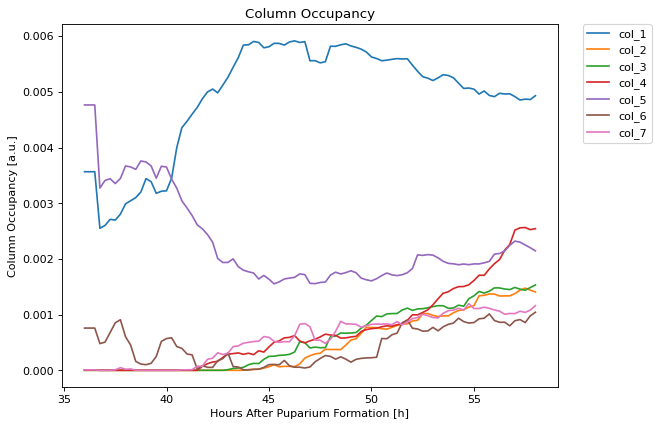

In [11]:
cols_hist = analysis.col_occupancy(stable_neuron, Cols, nor_fact=nor_fact, 
                                    start_t=start_age, 
                                    plot=True, save=True, 
                                    save_path=save_path, 
                                    save_file='stable_px_'+save_name)

calculating stable volume: 100%|██████████| 92/92 [00:00<00:00, 138.76it/s]


([156855,
  149582,
  145134,
  137124,
  142333,
  142510,
  134455,
  147569,
  151373,
  142732,
  150786,
  148616,
  144093,
  142834,
  142898,
  144861,
  159988,
  155380,
  157303,
  157945,
  166327,
  168110,
  152903,
  163517,
  165057,
  156571,
  158291,
  162491,
  170894,
  161443,
  167880,
  168114,
  170829,
  174006,
  158225,
  168047,
  156628,
  166198,
  162565,
  160503,
  160400,
  162464,
  170047,
  165860,
  179626,
  183199,
  188204,
  166137,
  175230,
  173580,
  179002,
  177387,
  189789,
  192356,
  194009,
  208770,
  202666,
  194504,
  195998,
  198519,
  199359,
  213078,
  217015,
  220731,
  222025,
  218724,
  225232,
  223150,
  228176,
  243802,
  227968,
  218382,
  230619,
  217822,
  237205,
  232761,
  240715,
  241831,
  249400,
  251917,
  237994,
  243951,
  238337,
  241697,
  249560,
  246597,
  262852,
  235091,
  255673,
  248270,
  259424,
  250496],
 [149582,
  149582,
  149582,
  109770,
  109984,
  107005,
  105505,
  107867,

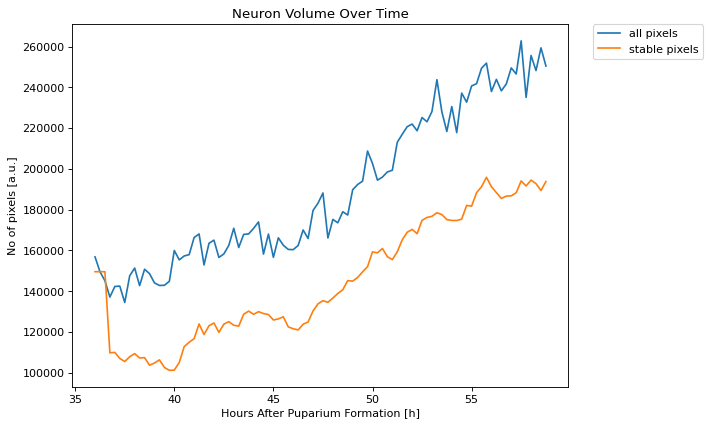

In [13]:
analysis.N_volume(neuron, stable_n, normalize=False, start_t=36, plot=True, save=True, save_path=save_path, save_file='Vol_'+save_name)

growth rate: 100%|██████████| 92/92 [00:01<00:00, 87.67it/s] 


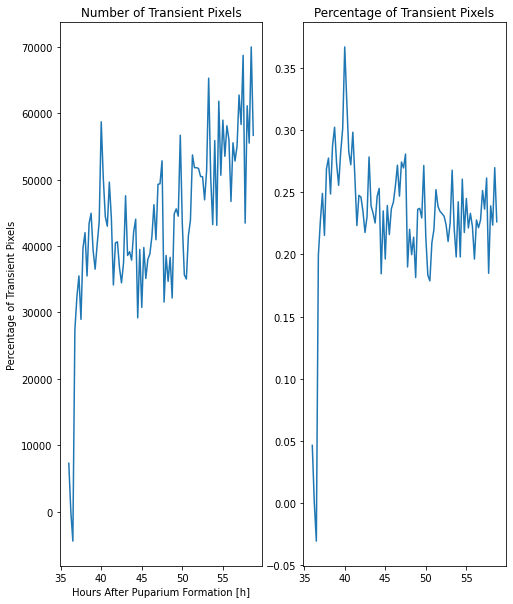

In [14]:
t, l = analysis.trans_px(neuron, stable_n, start_t=36, plot=True, save=True, save_path=save_path, save_file='transient_'+save_name)